<a href="https://www.kaggle.com/jaipawar/damaged-car-classifier?scriptVersionId=84726625" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Approach

1. Module imports
2. Configuration setup: Setting up required variables, seed and accelarator.
3. Dataset exploration: Checking out sample images, their shapes, classwise distribution.
4. Creating datasets: Used Keras ImageDataGenerators to create datasets directly from directories
5. Define model: Define a CNN model using TF Functional API, compile it with metrics: accuracy.
6. Train model: Train for 50 epochs, with EarlyStopping callback.
7. Plot metrics: Plot accuracy, loss w.r.t epochs
8. Evaluate model: Evaluate model on random test image.


Steps taken to increase accuracy:
1. Added image augumentations, only on training data
2. Used ReduceLROnPlateu and EarlyStopping callbacks
3. Increased patience of EarlyStopping to 5
4. Decreased patience of ReduceLROnPlateau to 1
5. Reduced EarlyStopping patience to 2

## Imports

In [1]:
# Built-in imports
import os
import sys
import random

# Image processing imports
import cv2

# Machine learning imports
import numpy as np; print('NUMPY Version:{}'.format(np.__version__))
import pandas as pd; print('PANDAS Version:{}'.format(pd.__version__))
import tensorflow as tf; print('TENSORFLOW Version:{}'.format(tf.__version__))

# Visualization imports
import matplotlib.pyplot as plt

NUMPY Version:1.19.5
PANDAS Version:1.3.4
TENSORFLOW Version:2.6.2


## Config

Setting up variables and accelarator

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50

DATA_DIR = '../input/car-damage-detection/data1a/'
train_dir = os.path.join(DATA_DIR, 'training/')
test_dir = os.path.join(DATA_DIR, 'validation/')

# Attempt at deterministic outputs(Reproducibility)
def seed_it_all(seed=7):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    #rng = np.random.default_rng(seed)
    
seed_it_all()

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    # On google colab (tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR'], pass tpu_address as param in below fn)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    #If no TPU, uncomment below to check for GPU
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## Dataset Exploration
Checking out sample images, their shapes, classwise distribution.

In [4]:
num_train_damaged = len(os.listdir(train_dir + '00-damage/'))
num_train_whole = len(os.listdir(train_dir + '01-whole/'))

print("Number of damaged train images:{}".format(num_train_damaged))
print("Number of whole train images:{}".format(num_train_whole))
print("Total train images:{}".format(num_train_damaged + num_train_whole))

print('\n')

num_test_damaged = len(os.listdir(test_dir + '00-damage/'))
num_test_whole = len(os.listdir(test_dir + '01-whole/'))

print("Number of damaged test images:{}".format(num_test_damaged))
print("Number of whole test images:{}".format(num_test_whole))
print("Total test images:{}".format(num_test_damaged + num_test_whole))

Number of damaged train images:920
Number of whole train images:920
Total train images:1840


Number of damaged test images:230
Number of whole test images:230
Total test images:460


**We can see that the dataset is balanced between both classes, in both the train and test sets.**

In [5]:
def display_multiple_img(image_dir, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: image_dir(string) - Path of directory with images
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8))
    for ind,image_path in enumerate(os.listdir(image_dir)):
        image = cv2.imread(image_dir + image_path, -1)
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_xlabel(image.shape)
        except:
            continue;
        
    plt.tight_layout()
    plt.show()

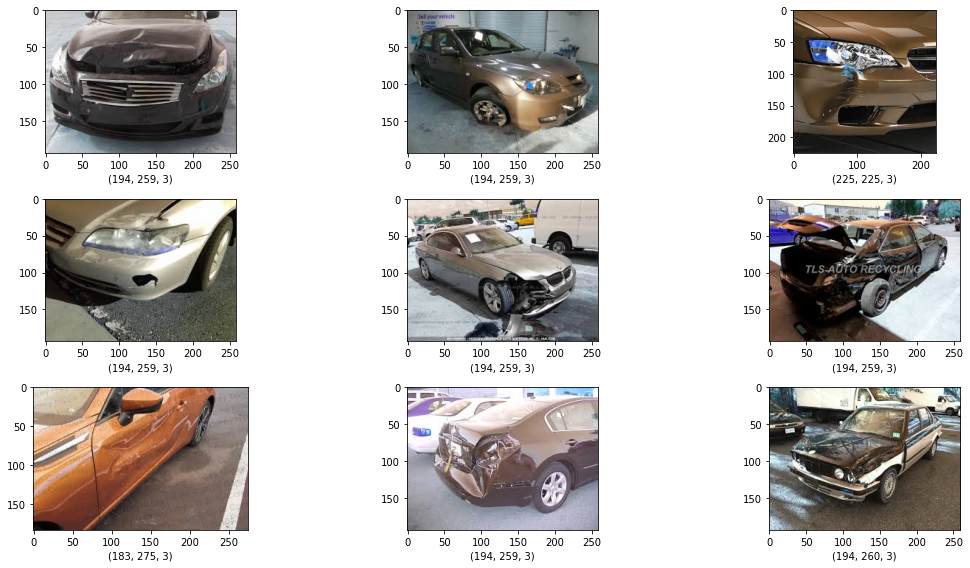

In [6]:
# Display damaged cars
display_multiple_img(train_dir + '00-damage/', 3, 3)

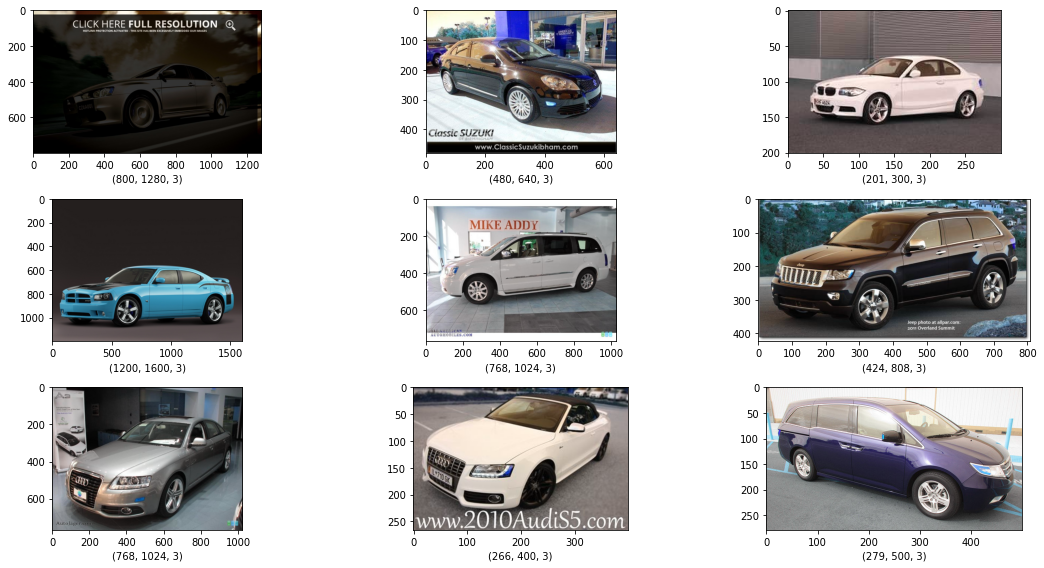

In [7]:
# Display undamaged cars
display_multiple_img(train_dir + '01-whole/', 3, 3)

## Create Datasets

* As seen in above plots, images are of different sizes, hence need to be reshaped. 
* We will carry out normalization and data augumentation using ImageDataGenerator below.


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory(train_dir,
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'binary')
                                         
test_dataset = test_datagen.flow_from_directory(test_dir,
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'binary')

test_dataset.class_indices

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


{'00-damage': 0, '01-whole': 1}

## Define Model

In [9]:
def block(x, filters, kernel_size, repetitions, pool_size=2, strides=2):
    for i in range(repetitions):
        x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)
    return x

In [10]:
def get_model():
    image_inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE , 3))
    x = block(image_inputs, 8, 3, 2)
    x = block(x, 16, 3, 2)
    x = block(x, 32, 3, 2)
    x = block(x, 64, 3, 2)
    x = block(x, 128, 3, 2)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs], outputs=[output])
    return model

In [11]:
model = get_model()

2022-01-08 12:18:22.473055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 12:18:22.564295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 12:18:22.565023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 12:18:22.566079: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.001)
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, patience=2, factor=0.2, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')

callbacks = [early_stopping, lr_reduction, model_checkpoint]

## Train model

In [13]:
history = model.fit(train_dataset, 
                    validation_data=test_dataset,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    batch_size=BATCH_SIZE)

2022-01-08 12:18:25.322024: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-08 12:18:27.179937: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


58/58 [==============================] - 28s 367ms/step - loss: 0.7691 - accuracy: 0.5348 - val_loss: 0.6933 - val_accuracy: 0.5043

Epoch 00001: val_accuracy improved from -inf to 0.50435, saving model to best_model.hdf5
Epoch 2/50
58/58 [==============================] - 18s 307ms/step - loss: 0.6962 - accuracy: 0.5413 - val_loss: 0.7068 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50435
Epoch 3/50
58/58 [==============================] - 19s 324ms/step - loss: 0.6949 - accuracy: 0.5473 - val_loss: 0.7413 - val_accuracy: 0.5022

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00003: val_accuracy did not improve from 0.50435
Epoch 4/50
58/58 [==============================] - 17s 300ms/step - loss: 0.6909 - accuracy: 0.5337 - val_loss: 0.6746 - val_accuracy: 0.6087

Epoch 00004: val_accuracy improved from 0.50435 to 0.60870, saving model to best_model.hdf5
Epoch 5/50
58/58 [==============================] - 19s 323ms/

## Plot metrics

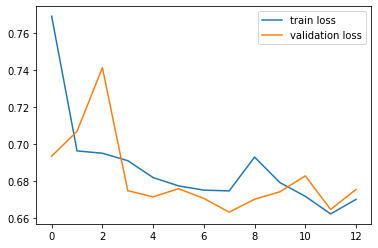

In [14]:
plt.plot(history.history['loss'], label='train loss') 
plt.plot(history.history['val_loss'], label='validation loss') 
plt.legend()
plt.show()

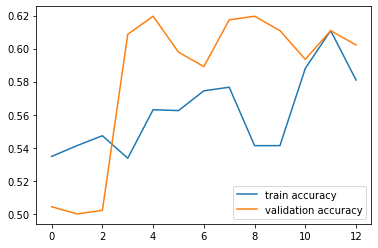

In [15]:
plt.plot(history.history['accuracy'], label='train accuracy') 
plt.plot(history.history['val_accuracy'], label='validation accuracy') 
plt.legend()
plt.show()

In [16]:
print('Validation accuracy achieved', history.history['val_accuracy'][-2])

Validation accuracy achieved 0.6108695864677429


## Evaluate model

In [17]:
def predictImage(filename):
    
    img = cv2.imread(filename)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    
    Y = np.array(img)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val < 0.5:
        plt.xlabel("Car Damaged",fontsize=30)
    elif val >= 0.5:
        plt.xlabel("Car Not Damaged",fontsize=30)

[[56.05462]]


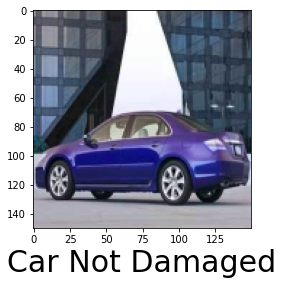

In [18]:
predictImage("../input/car-damage-detection/data1a/validation/01-whole/0001.jpg")